In [1]:

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.visualization import plot_histogram
import random


"""

reglas Metamórficas implementadas para el algoritmo de Bernstein–Vazirani:

I) Si aplicamos el algoritmo a f_s y f_s1 por separado, donde s1 es el complementario binario de s,
        y luego sumamos ambos resultados, deberíamos obtener el ket |1> de dimensión len(s).
        
II) Si aplicamos el algoritmo a f_s y f_s1 por separado y se realiza la suma bit a bit de ambos resultados, 
        debería obtenerse s (+_b) s1. Nótese que (+_b) denota la suma bit a bit de cadenas de misma longitud.

III) Al aplicar al algoritmo concatenando los oráculos de dos funciones f_s y f_s1, se debe obtener s (+_b) s1.


"""



# Función que genera aleatoriamente las cadenas s y s1, para las distintas reglas
def sMT_generator(rule, length):
    s, s1 = '', ''
    
    # Para la primera regla, s1 debe ser el complementario binario de s
    if rule == 1:
        for i in range(length):
            k = random.randint(0,1)
            s += str(k)
            s1 += str(1-k)
                
    else:
        for i in range(length):
            k, l = random.randint(0,1), random.randint(0,1)
            s += str(k)
            s1 += str(l)
            
    return s, s1



# Función que genera los oráculos de f_s y/o f_s1 para las distintas reglas
def bv_fgenerator(s): 
    
    length = len(s)
    s = s[::-1]
    qc = QuantumCircuit(length + 1)
    
    for q in range(length):
        if s[q] == '0':
            qc.i(q) # añadimos la puerta identidad para indicar que no se realiza ninguna acción
        else:
            qc.cx(q, length) # añadimos una puerta CNOT conectando este qubit con el qubit ancilla
            
    return qc



# Función que genera el circuito original del Algoritmo de Bernstein-Vazirani
def bernstein_vazirani(s):
    length = len(s)
    
    # Inicializamos el registro y creamos el circuito cuántico
    qs = QuantumRegister(length, 's')
    anc = QuantumRegister(1, 'anc')
    c_bits = ClassicalRegister(length, 'c_bits')
    qc = QuantumCircuit(qs, anc, c_bits)
    
    # Colocamos todos los qubits en estado de superposición con las puertas de Hadamard
    for i in range(length + 1):
        qc.h(i)
    qc.z(length) # aplicamos la puerta Z de Pauli al qubit ancilla
    
    qc.barrier()
        
    # Generamos el oráculo de f_s y lo transformamos a puerta cuántica para ocultar su estructura
    f = bv_fgenerator(s)
    f_s = f.to_gate(label = '  f_s  \n \ns = ' + s)
    qc.append(f_s, range(length + 1)) # añadimos el oráculo generado
    
    qc.barrier()
    
    # Revertimos los efectos de la superposición inicial, ya que H es su propia inversa
    for i in range(length):
        qc.h(i)
        
    qc.barrier()
    
    # Medimos el valor al que han colapsado los n primeros qubits
    for i in range(length):
        qc.measure(i, i)
    
    return qc
    
    

# Función que genera el circuito para la suma bit a bit de dos cadenas de misma longitud
def sum_bit_to_bit_gate(length): 
    
    qubits = 3*length + 2
    qc = QuantumCircuit(qubits)
    
    for i in range(length):
        qc.cx(length - i - 1, qubits - i - 1)
        qc.cx(2*length - i, qubits - i - 1)
        
    return qc



# Función que añade al circuito las puertas necesarias para la regla indicada y hace las mediciones correspondientes
def bv_testSetUp(rule, qc, length):
    
    # Cuando se tenga la última regla se realizan las mediciones como en el circuito original
    if rule == 3:
        for i in range(length):
            qc.measure(i, i)
    
    
    # Dado que I es un caso particular de II, su finalización es idéntica
    else:
        suma = sum_bit_to_bit_gate(length)
        sgate = suma.to_gate(label = '  suma  \n bit a bit')
        qc.append(sgate, range(3*length + 2))
        
        for i in range(length):
            qc.measure(2*(length + 1) + i, i)
            
            
            
# Función que devuelve el circuito cuántico correspondiente, dada una regla y una longitud de cadena            
def bv_MT(rule, length):
    
    # Generamos las cadenas de bits s y s1
    s, s1 = sMT_generator(rule, length)
    
    # Creamos sendos nombres para los oráculos que generaremos acorde a cada valor
    # incluyendo los valores de s y s1, para poder interpretar los resultados obtenidos
    
    nameS = '  f_s  \n \ns = ' + s
    nameS1 = '  f_s1  \n \ns1 = ' + s1
    
    # Generamos los oráculos y los convertimos en puertas cuánticas con sus respectivos nombres
    f = bv_fgenerator(s)
    f_s = f.to_gate(label = nameS)
    
    f1 = bv_fgenerator(s1)
    f_s1 = f1.to_gate(label = nameS1)
    
    # Según la regla a estudiar, procederemos a la creación del circuito cuántico correspondiente
    
    if rule == 3:
        
        # Inicializamos el registro y creamos el circuito cuántico
        qs = QuantumRegister(length, 's')
        anc1 = QuantumRegister(1, 'anc1')
        c_test = ClassicalRegister(length, 'c_test')
        qc = QuantumCircuit(qs, anc1, c_test)
        
        # Colocamos todos los qubits en estado de superposición con las puertas de Hadamard
        for i in range(length+1):
            qc.h(i)
        
        # Aplicamos la puerta Z a nuestro qubit ancilla
        qc.z(length)
        qc.barrier()
        
        # Añadimos los oráculos generados
        qc.append(f_s, range(length + 1))
        qc.barrier()
        
        qc.append(f_s1, range(length + 1))
        qc.barrier()
        
        # Revertimos los efectos de la superposición inicial, ya que H es su propia inversa
        for i in range(length):
            qc.h(i)
        qc.barrier()
        
    else:
        
        # Inicializamos el registro y creamos el circuito cuántico
        qs = QuantumRegister(length, 's')
        anc1 = QuantumRegister(1, 'anc1')
        qs1 = QuantumRegister(length, 's1')
        anc2 = QuantumRegister(1, 'anc2')
        q_test = QuantumRegister(length, 'q_test')
        c_test = ClassicalRegister(length, 'c_test')
        qc = QuantumCircuit(qs, anc1, qs1, anc2, q_test, c_test)
        
        # Ponemos los qubits necesarios en superposición usando puertas de Hadamard
        for i in range(2*(length+1)):
            qc.h(i)
            
        # Aplicamos la puerta Z a nuestros qubits ancilla, uno para cada oráculo
        qc.z(length)
        qc.z(2*length + 1)
        qc.barrier()
    
        # Añadimos los oráculos generados para los qubits adecuados
        qc.append(f_s, range(length + 1))
        qc.append(f_s1, range(length + 1, 2*length + 2))
        qc.barrier()
        
        # Revertimos los efectos de la superposición inicial, ya que H es su propia inversa
        for i in range(length):
            qc.h(i)
        for i in range(length + 1, 2*length + 1):
            qc.h(i) 
        qc.barrier()
    
    # Añadimos las puertas cuánticas restantes para cada regla (mediciones y/o suma bit a bit)
    bv_testSetUp(rule, qc, length)
    
    return qc


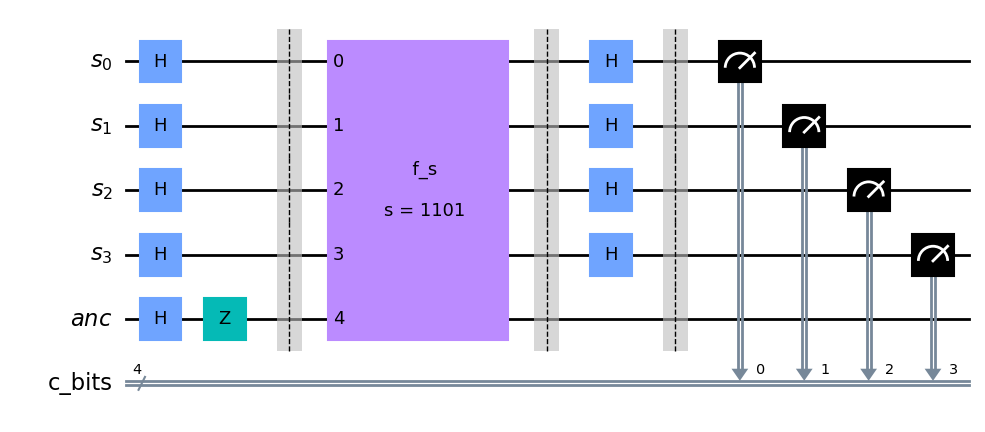

In [2]:

# Creamos el circuito cuántico del programa que resuelve el Algoritmo de Bernstein-Vazirani para s
s = '1101'
algorithm = bernstein_vazirani(s)
algorithm.draw(output = 'mpl')


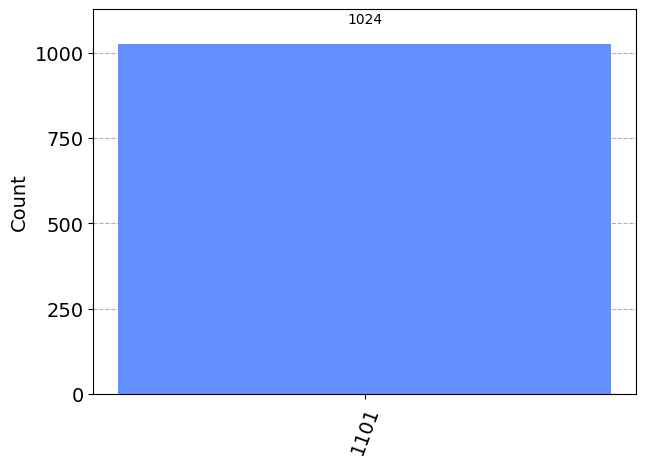

In [3]:

# Simulación del Algoritmo de Bernstein-Vazirani con la cadena de bits s
aer_sim = Aer.get_backend('qasm_simulator')
transpiled_algorithm = transpile(algorithm, aer_sim)
results = aer_sim.run(transpiled_algorithm).result()
counts = results.get_counts()
plot_histogram(counts)


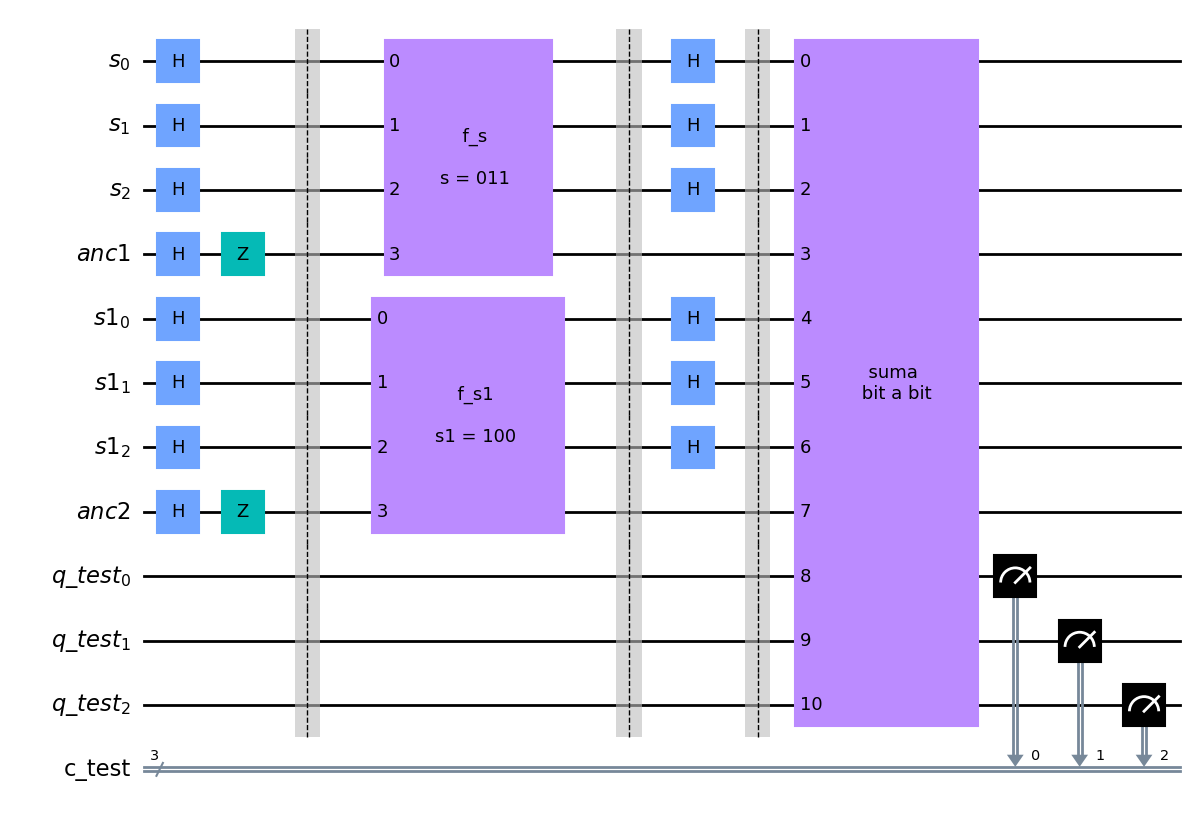

In [4]:

# Test para la regla I. Creamos y visualizamos el circuito cuántico
test1 = bv_MT(rule = 1, length = 3)
test1.draw(output = 'mpl')


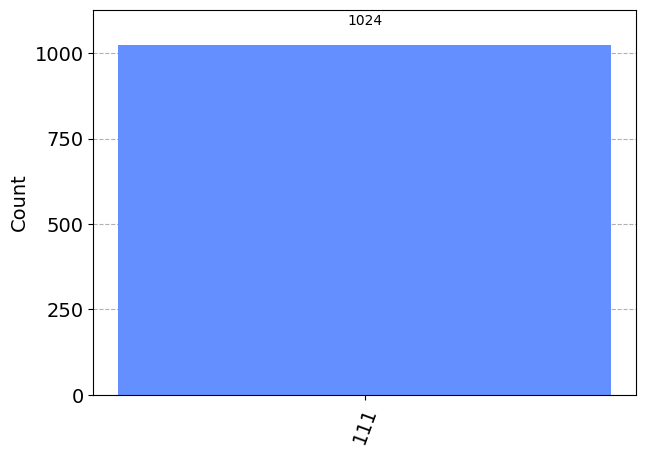

In [5]:

# Simulación teórica del circuito genereado para el test de la regla I
# Resultado esperado: |1...1>

sim = Aer.get_backend('qasm_simulator')
transpiled_algorithm = transpile(test1, sim)
results = sim.run(transpiled_algorithm).result()
answer = results.get_counts()
plot_histogram(answer)


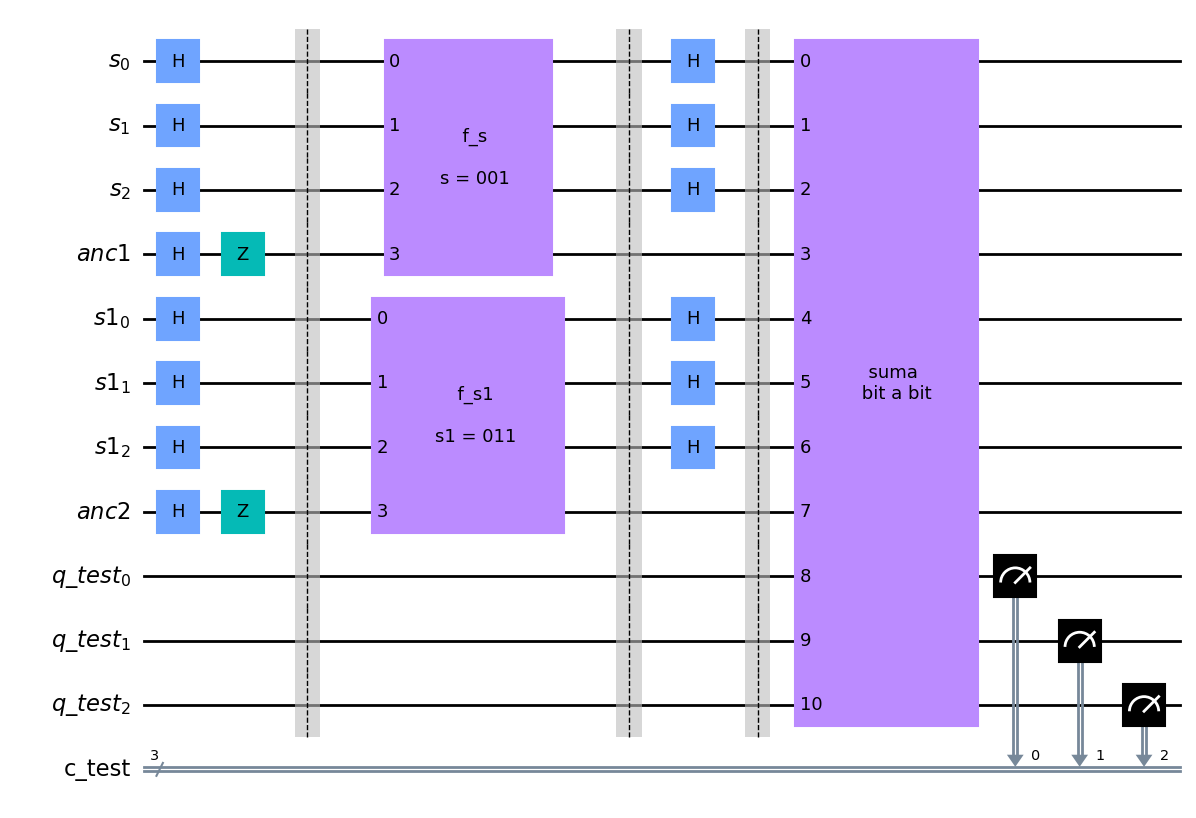

In [6]:

# Test para la regla II. Creamos y visualizamos el circuito cuántico
test2 = bv_MT(rule = 2, length = 3)
test2.draw(output = 'mpl')


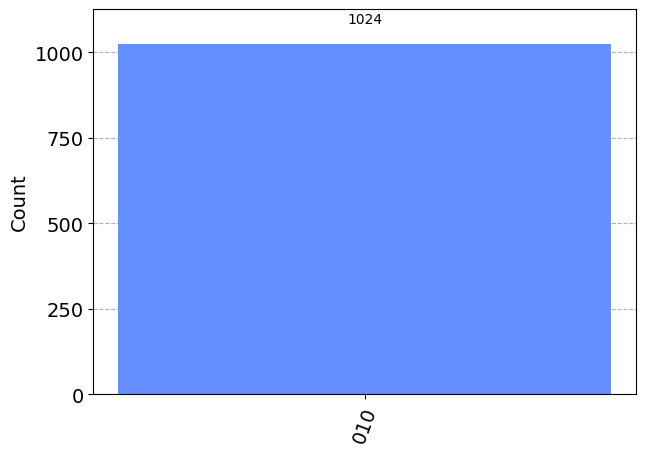

In [7]:

# Simulación teórica del circuito genereado para el test de la regla II
# Resultado esperado: s (+_b) s1

sim = Aer.get_backend('qasm_simulator')
transpiled_algorithm = transpile(test2, sim)
results = sim.run(transpiled_algorithm).result()
answer = results.get_counts()
plot_histogram(answer)


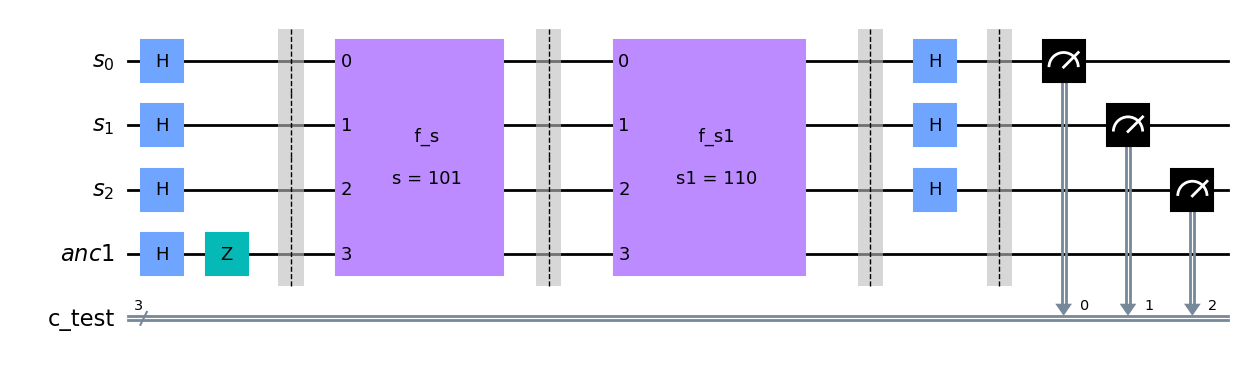

In [8]:

# Test para la regla III. Creamos y visualizamos el circuito cuántico
test3 = bv_MT(rule = 3, length = 3)
test3.draw(output = 'mpl')


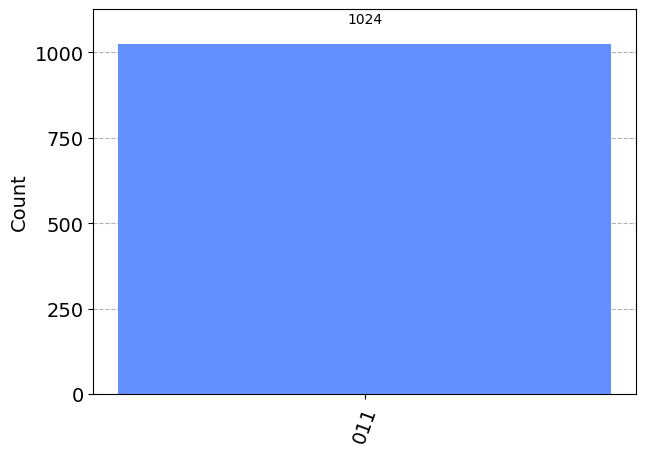

In [9]:

# Simulación teórica del circuito genereado para el test de la regla III
# Resultado esperado: s (+_b) s1

sim = Aer.get_backend('qasm_simulator')
transpiled_algorithm = transpile(test3, sim)
results = sim.run(transpiled_algorithm).result()
answer = results.get_counts()
plot_histogram(answer)
